# Useful Resources

- https://colab.research.google.com/github/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb

# Prepare

In [1]:
# !pip install -q tqdm
# !pip install -q conllu
# !pip install -q seaborn
# !pip install -q datasets
# !pip install -q scikit-learn
# !pip install -q pytorch_lightning
# !pip install -q git+https://github.com/MagedSaeed/tkseem

run the below line when needed, like in jupyter lab to access dotless_arabic folder.

In [2]:
# %cd ../../../.. 

In [3]:
import re
import os
import random
import string
import shutil
from pathlib import Path
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
    Callback,
    RichProgressBar,
)

import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login


import tkseem as tk
from tqdm.auto import tqdm

from dotless_arabic.processing import undot
from dotless_arabic.callbacks import EpochTimerCallback

In [4]:
seed = 42

In [5]:
# notebook_login() # in case of not being logged in, uncomment

In [6]:
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

seed_everything(seed)

Global seed set to 42


42

In [7]:
tqdm.pandas()

In [8]:
nltk.download('stopwords')
stopwords = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/majed_alshaibani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load and explore the dataset

In [9]:
# make sure to login to huggingface and replace MagedSaeed with your name as the dataset is private
train_dataset = datasets.concatenate_datasets([
  datasets.load_dataset("MagedSaeed/ANERcorp")['train'],
])
train_dataset

Dataset({
    features: ['tokens', 'tags', 'tags_labels'],
    num_rows: 3972
})

In [10]:
train_validation_dataset = train_dataset.train_test_split(test_size=0.1,seed=seed,shuffle=True)
train_dataset = train_validation_dataset['train']
validation_dataset = train_validation_dataset['test']
train_dataset,validation_dataset

(Dataset({
     features: ['tokens', 'tags', 'tags_labels'],
     num_rows: 3574
 }),
 Dataset({
     features: ['tokens', 'tags', 'tags_labels'],
     num_rows: 398
 }))

In [11]:
# make sure to login to huggingface and replace MagedSaeed with your name as the dataset is private
test_dataset = datasets.concatenate_datasets([
datasets.load_dataset("MagedSaeed/ANERcorp")['test'],
])
test_dataset

Dataset({
    features: ['tokens', 'tags', 'tags_labels'],
    num_rows: 924
})

Converting to Pandas and droping duplicates

In [12]:
train_dataset = train_dataset.to_pandas()
train_dataset

,tokens,tags,tags_labels
0,"[واعاد, راوول, الفارق, الى, سابق, عهده, عندما,...","[O, B-PERS, O, O, O, O, O, O, O, O, O, O, O, B...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,"[وبحسب, الصحيفة, فإن, شركة, طيران, ريان, إير, ...","[O, O, O, O, O, B-ORG, I-ORG, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 7, 2, 0, 0, 0, 0, 0, 0]"
2,"[4, ليتر, يولدان, قوة, 110أحصنة, و148حصاناً, ع...","[O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[وفقدت, البرازيل, لقبها, بطلة, للعالم, بخسارته...","[O, B-LOC, O, O, O, O, O, B-LOC, O, O, O, O, O...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,"[واعتبر, ان, "", سسياستنا, الدبلوماسية, تهدف, ب...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
3569,"[وكانت, هذه, هي, اخر, مباراة, في, جولة, النادي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-O...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, ..."
3570,"[ولقد, ظلت, ثورة, الملك, والشعب, النبراس, الذي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3571,"[لأنهم, بدلاء, للسلطة, «, .]","[O, O, O, O, O]","[0, 0, 0, 0, 0]"
3572,"[فقال, :, -, نجيب, محفوظ, ترك, أثره, على, الجم...","[O, O, O, B-PERS, I-PERS, O, O, O, O, O, O, O,...","[0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
train_dataset = train_dataset.drop_duplicates(subset=['tokens'],keep='first').copy()
train_dataset

,tokens,tags,tags_labels
0,"[واعاد, راوول, الفارق, الى, سابق, عهده, عندما,...","[O, B-PERS, O, O, O, O, O, O, O, O, O, O, O, B...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,"[وبحسب, الصحيفة, فإن, شركة, طيران, ريان, إير, ...","[O, O, O, O, O, B-ORG, I-ORG, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 7, 2, 0, 0, 0, 0, 0, 0]"
2,"[4, ليتر, يولدان, قوة, 110أحصنة, و148حصاناً, ع...","[O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[وفقدت, البرازيل, لقبها, بطلة, للعالم, بخسارته...","[O, B-LOC, O, O, O, O, O, B-LOC, O, O, O, O, O...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,"[واعتبر, ان, "", سسياستنا, الدبلوماسية, تهدف, ب...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
3569,"[وكانت, هذه, هي, اخر, مباراة, في, جولة, النادي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-O...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, ..."
3570,"[ولقد, ظلت, ثورة, الملك, والشعب, النبراس, الذي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3571,"[لأنهم, بدلاء, للسلطة, «, .]","[O, O, O, O, O]","[0, 0, 0, 0, 0]"
3572,"[فقال, :, -, نجيب, محفوظ, ترك, أثره, على, الجم...","[O, O, O, B-PERS, I-PERS, O, O, O, O, O, O, O,...","[0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
validation_dataset = validation_dataset.to_pandas()
validation_dataset

,tokens,tags,tags_labels
0,"[بعد, هزيمته, في, الدورة, الأولى, في, ديربي, ع...","[O, O, O, O, O, O, B-MISC, B-LOC, B-LOC, O, B-...","[0, 0, 0, 0, 0, 0, 8, 1, 1, 0, 7, 2, 0, 0, 7, ..."
1,"[وكان, جلالة, الملك, محمد, السادس, وصاحب, السم...","[O, O, O, B-PERS, I-PERS, O, O, O, O, O, B-PER...","[0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, ..."
2,"[وكانت, اعمدة, الدخان, تتصاعد, من, موقعين, في,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[6%, خلال, النصف, الأول, من, العام, 2006, مقار...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[الحقيقة, ندركها, حين, نجرب, الدخول, إلى, أحد,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-O...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, ..."
...,...,...,...
393,"[يقول, :, », إنه, يقع, في, أقصى, لعبة, الشطرنج...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
394,"[والذي, لا, يعرفه, عدد, كبير, من, الناس, ,, أن...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
395,"[تم, استعمال, الأسلحة, الكيميائية, في, تلك, ال...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
396,"[واضاف, ان, التقرير, الطبي, أكد, حاجة, صدام, إ...","[O, O, O, O, O, O, B-PERS, O, O, O, O]","[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0]"


In [15]:
validation_dataset = validation_dataset.drop_duplicates(subset=['tokens'],keep='first').copy()
validation_dataset

,tokens,tags,tags_labels
0,"[بعد, هزيمته, في, الدورة, الأولى, في, ديربي, ع...","[O, O, O, O, O, O, B-MISC, B-LOC, B-LOC, O, B-...","[0, 0, 0, 0, 0, 0, 8, 1, 1, 0, 7, 2, 0, 0, 7, ..."
1,"[وكان, جلالة, الملك, محمد, السادس, وصاحب, السم...","[O, O, O, B-PERS, I-PERS, O, O, O, O, O, B-PER...","[0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, ..."
2,"[وكانت, اعمدة, الدخان, تتصاعد, من, موقعين, في,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[6%, خلال, النصف, الأول, من, العام, 2006, مقار...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"[الحقيقة, ندركها, حين, نجرب, الدخول, إلى, أحد,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-O...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, ..."
...,...,...,...
393,"[يقول, :, », إنه, يقع, في, أقصى, لعبة, الشطرنج...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
394,"[والذي, لا, يعرفه, عدد, كبير, من, الناس, ,, أن...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
395,"[تم, استعمال, الأسلحة, الكيميائية, في, تلك, ال...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
396,"[واضاف, ان, التقرير, الطبي, أكد, حاجة, صدام, إ...","[O, O, O, O, O, O, B-PERS, O, O, O, O]","[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0]"


In [16]:
test_dataset = test_dataset.to_pandas()
test_dataset

,tokens,tags,tags_labels
0,"[الصالحية, المفرق, -, غيث, الطراونة, -, أمر, ج...","[B-LOC, B-LOC, O, B-PERS, I-PERS, O, O, O, O, ...","[1, 1, 0, 4, 5, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, ..."
1,"[برند, جلالته, خلال, اللقاء, الذي, جمعه, وأعضا...","[B-PERS, O, O, O, O, O, O, O, O, O, O, O, O, O...","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[مرتفع, جلالته, أريد, ان, استمع, منكم, عن, الم...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[زادت, جلالته, على, انه, سوف, يعود, الى, الباد...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[لصادرات, جلالة, الملك, اطلق, في, ايار, الماضي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
919,"[الإلكترون, الرغم, من, تصريحه, أكثر, من, مرة, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
920,"["", الأمير, السعودي, في, قطاعات, استثمارية, مت...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 2, ..."
921,"[وتتهم, بن, طلال, شهادة, البكالوريوس, في, إدار...","[O, I-PERS, I-PERS, O, O, O, O, O, O, O, O, O,...","[0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
922,"[ذلك, ،, يتابع, الوليد, بن, طلال, أعماله, التج...","[O, O, O, B-PERS, I-PERS, B-PERS, O, O, O, O, ...","[0, 0, 0, 4, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
test_dataset = test_dataset.drop_duplicates(subset=['tokens'],keep='first').copy()
test_dataset

,tokens,tags,tags_labels
0,"[الصالحية, المفرق, -, غيث, الطراونة, -, أمر, ج...","[B-LOC, B-LOC, O, B-PERS, I-PERS, O, O, O, O, ...","[1, 1, 0, 4, 5, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, ..."
1,"[برند, جلالته, خلال, اللقاء, الذي, جمعه, وأعضا...","[B-PERS, O, O, O, O, O, O, O, O, O, O, O, O, O...","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[مرتفع, جلالته, أريد, ان, استمع, منكم, عن, الم...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[زادت, جلالته, على, انه, سوف, يعود, الى, الباد...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[لصادرات, جلالة, الملك, اطلق, في, ايار, الماضي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
919,"[الإلكترون, الرغم, من, تصريحه, أكثر, من, مرة, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
920,"["", الأمير, السعودي, في, قطاعات, استثمارية, مت...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 2, ..."
921,"[وتتهم, بن, طلال, شهادة, البكالوريوس, في, إدار...","[O, I-PERS, I-PERS, O, O, O, O, O, O, O, O, O,...","[0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
922,"[ذلك, ،, يتابع, الوليد, بن, طلال, أعماله, التج...","[O, O, O, B-PERS, I-PERS, B-PERS, O, O, O, O, ...","[0, 0, 0, 4, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
test_dataset['tokens'][0],test_dataset['tags_labels'][0]

(array(['الصالحية', 'المفرق', '-', 'غيث', 'الطراونة', '-', 'أمر', 'جلالة',
        'الملك', 'عبدالله', 'الثاني', 'أمس', 'بتنفيذ', 'حزمة', 'من',
        'المشاريع', 'التعليمية', 'والصحية', 'والتنموية', 'وأخرى', 'مرتبطة',
        'بالأندية', 'الشبابية', 'و', '27', 'وحدة', 'سكنية', 'في', 'قضاء',
        'الصالحية', 'ونايفة', 'في', 'البادية', 'الشرقية', 'خلال', 'ستة',
        'اشهر', 'بتمويل', 'من', 'الديوان', 'الملكي', 'الهاشمي', '.'],
       dtype=object),
 array([1, 1, 0, 4, 5, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

delete the tokens class 13 as it is placeholder for connected words "as far as I understand from the above example"

In [19]:
number_of_tags = len(set([tag for tags in train_dataset['tags_labels'] for tag in tags]))
number_of_tags

9

Count positives and negatives

<BarContainer object of 9 artists>

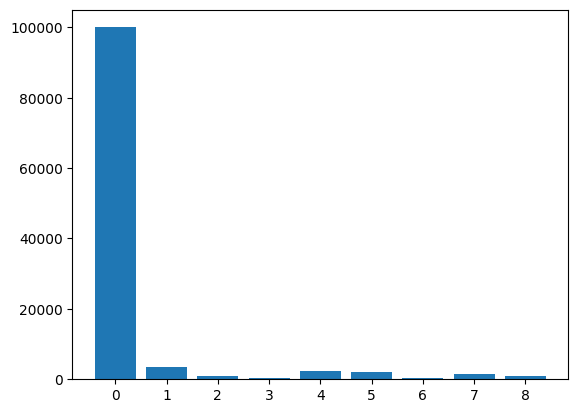

In [20]:
# Create a count plot
tags = [tag for sample in train_dataset['tags_labels'] for tag in sample]
tags_counter = Counter(tags)
plt.xticks(range(number_of_tags))
plt.bar(tags_counter.keys(),tags_counter.values())

In [21]:
tags_counter.most_common()

[(0, 100003),
 (1, 3406),
 (4, 2441),
 (5, 1977),
 (7, 1411),
 (2, 1005),
 (8, 799),
 (3, 490),
 (6, 340)]

In [22]:
sum(tags_counter.values())

111872

testset and trainset vocabulary and tokens count:


In [23]:
vocabs_dict = {}
for tokens_list in test_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('9,073', '24,996')

In [24]:
vocabs_dict = {}
for tokens_list in validation_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('6,300', '13,204')

In [25]:
vocabs_dict = {}
for tokens_list in train_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('27,282', '111,872')

# create helper functions and set constants

In [26]:
max(map(len,train_dataset['tokens'])),max(map(len,test_dataset['tokens']))

(217, 146)

In [27]:
# setting seq_len:
seq_len = 220
pad_tag = number_of_tags # tags starts from zero :)

In [28]:
def create_features_from_tokens_list(tokens_list,tags_list,tokenizer):
  encoded = list()
  padded_tags = list()
  for tokens,tags in tqdm(zip(tokens_list,tags_list)):
    text = ' '.join(tokens)
    encoded_doc = tokenizer.encode(text)
    encoded_doc = tokenizer.pad(encoded_doc,length=seq_len)
    encoded_doc = encoded_doc[:seq_len]
    encoded.append(np.array(encoded_doc))
    tags = tags[:seq_len]
    padded_tags.append(np.pad(
        tags,
        pad_width=(0,seq_len-len(tags)),
        constant_values=pad_tag,
      )
    )
  return np.array(encoded),np.array(padded_tags)

In [29]:
# define batch size
batch_size = 256

# Build the BiLSTM Model

## The Model Architecture

In [30]:
# model architecture (with some amends)
# https://www.kaggle.com/code/affand20/imdb-with-pytorch

class LitBiLSTMModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        pad_id=1, # the default value from tkseem tokenizers
        pad_tag=pad_tag,
        seq_len=seq_len,
        output_size=number_of_tags+1, # one class is added for padding
        hidden_size=512,
        embedding_size=256,
        embedding_dropout=0.5,
        dropout=0.5,
        learning_rate=0.001,
        n_layers=3,
        bidirectional=True,
      ):
        super().__init__()

        self.save_hyperparameters()

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout_prop = dropout
        self.pad_tag = pad_tag
        self.pad_id = pad_id
        self.max_sequence_length = seq_len
        self.output_size = output_size

        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.test_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        
        self.test_recall = torchmetrics.Recall(
            average='macro',
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
      
        self.test_precision = torchmetrics.Precision(
            average='macro',
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        
        self.test_f1_score = torchmetrics.F1Score(
            average='macro',
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(
              embedding_size,
              hidden_size,
              n_layers,
              dropout=dropout,
              batch_first=True,
              bidirectional=bidirectional,
        )

        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        outputs = self.embedding(inputs)
        outputs = self.embedding_dropout(outputs) # apply dropout on embedding
        inputs_lengths = torch.sum(inputs!=self.pad_id,axis=-1).cpu()
        packed_outputs = nn.utils.rnn.pack_padded_sequence(
            outputs,
            inputs_lengths,
            batch_first=True,
            enforce_sorted=False,
          )
        if not self.bidirectional:
          # pass forward to lstm
          packed_outputs, _ =  self.lstm(packed_outputs)
          outputs,lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        else:
          bidirectional_packed_outputs,_ = self.lstm(packed_outputs)
          bidirectional_outputs,lengths = nn.utils.rnn.pad_packed_sequence(
              bidirectional_packed_outputs,
              batch_first=True,
              # padding_value=self.pad_id,
              total_length=self.max_sequence_length,
            )
          outputs = bidirectional_outputs[:, :, : self.hidden_size] + bidirectional_outputs[:, :, self.hidden_size :]
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        # softmax will be done in the loss calculation
        return outputs

    def step(self, inputs, labels):
        assert torch.sum(inputs==self.pad_id)==torch.sum(labels==self.pad_tag),\
             f'pad ids and their target tags does not match: {torch.sum(inputs==self.pad_id):=} != {torch.sum(labels==self.pad_tag):=}'
        outputs = self(inputs)
        outputs = outputs.squeeze()
        outputs = outputs.view(outputs.shape[0]*outputs.shape[1],-1)
        labels = labels.view(-1)
        return outputs,labels

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        test_accuracy = self.test_accuracy(outputs,labels)
        test_precision = self.test_precision(outputs,labels)
        test_recall = self.test_recall(outputs,labels)
        test_f1_score = self.test_f1_score(outputs,labels)
        metrics = {
          "test_acc": test_accuracy,
          "test_precision": test_precision,
          "test_recall": test_recall,
          "test_f1_score": test_f1_score,
          "test_loss": loss,
          
        }
        self.log_dict(metrics, prog_bar=True)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.5,
            patience=1,
            verbose=True,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

## util classes/functions

In [31]:
class ConfusionMatrixCallback(Callback):
  def __init__(self,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.predictions = list()
    self.labels = list()

  def on_test_batch_end(self,trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
    super().on_test_batch_end(
        trainer,
        pl_module,
        outputs,
        batch,
        batch_idx,
        dataloader_idx,
      )
    inputs,labels = batch
    outputs = outputs.view(inputs.shape[0]*inputs.shape[1],-1)
    batch_predictions = torch.argmax(outputs,dim=-1)
    self.predictions.append(batch_predictions)
    labels = labels.view(-1)
    self.labels.append(labels)

  def on_test_end(self, trainer, pl_module) -> None:
     super().on_test_end(trainer, pl_module)
     predictions = torch.cat(self.predictions).cpu()
     labels = torch.cat(self.labels).cpu()
     confusion_matrix_calculator = torchmetrics.ConfusionMatrix(
            task="multiclass",
            num_classes=trainer.model.output_size,
            ignore_index=trainer.model.pad_tag,
     )
     confusion_matrix = confusion_matrix_calculator(predictions,labels)
     # zero out lists for future calculations
     self.predictions = list()
     self.labels = list()
     plt.figure(figsize = (10,7))
     sns.heatmap(confusion_matrix, annot=True,linewidths=0.5,fmt='g',cmap='Blues')

In [32]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    text_type,
    max_epochs=50,
):
    checkpoints_path = Path(f"./NER/{text_type}")
    shutil.rmtree(checkpoints_path, ignore_errors=True)
    checkpoint_callback = ModelCheckpoint(
        mode="min",
        save_top_k=1,
        verbose=False,
        save_last=True,
        monitor="val_loss",
        save_weights_only=False,
        auto_insert_metric_name=True,
        save_on_train_epoch_end=False,
        dirpath=f"{checkpoints_path}/checkpoints",
        filename="{epoch}-{val_loss:.3f}-{step}",
    )
    callbacks = list()
    callbacks.append(checkpoint_callback)
    confusion_matrix_callback = ConfusionMatrixCallback()
    callbacks.append(confusion_matrix_callback)
    callbacks.append(RichProgressBar())
    early_stopping_callback = EarlyStopping(
        monitor="val_loss",
        # min_delta=0.025,
        min_delta=0,
        patience=10,
        check_finite=True,
    )
    callbacks.append(early_stopping_callback)
    lr_monitor = LearningRateMonitor(
        logging_interval="step",
        log_momentum=True,
    )
    callbacks.append(lr_monitor)
    callbacks.append(EpochTimerCallback(log_results=False))
    devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainer = Trainer(
        deterministic=True,
        callbacks=callbacks,
        gradient_clip_val=5,
        fast_dev_run=False,
        max_epochs=max_epochs,
        val_check_interval=0.5,
        accelerator="auto",
        devices=[0],
        # log_every_n_steps=max(len(train_dataloader) // 25, 1),
        log_every_n_steps=max(len(train_dataloader) // 25, 1),
    )
    trainer.validate(
        model=model,
        dataloaders=val_dataloader,
    )
    trainer.fit(
        model,
        train_dataloader,
        val_dataloader,
    )
    return trainer

# Dotted Text

## Prepare the tokenizer

In [33]:
tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [34]:
tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['tokens']))

Training WordTokenizer ...


In [35]:
tokenizer.vocab_size

27284

In [36]:
# test the tokenizer
tokenizer.tokenize('السلام على , hello')

['السلام', 'على', ',', '<UNK>']

## tokenize and split

In [37]:
encoded_trainset,trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['tokens'],
    tags_list=train_dataset['tags_labels'],
    tokenizer=tokenizer,
  )
encoded_valset,valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['tokens'],
    tags_list=validation_dataset['tags_labels'],
    tokenizer=tokenizer,
  )
encoded_testset,testy = create_features_from_tokens_list(
    tokens_list=test_dataset['tokens'],
    tags_list=test_dataset['tags_labels'],
    tokenizer=tokenizer,
  )
encoded_trainset.shape,trainy.shape,encoded_valset.shape,valy.shape,encoded_testset.shape,testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((3574, 220), (3574, 220), (398, 220), (398, 220), (924, 220), (924, 220))

In [38]:
# create tensor datasets
trainset = TensorDataset(torch.from_numpy(encoded_trainset), torch.from_numpy(trainy))
validset = TensorDataset(torch.from_numpy(encoded_valset), torch.from_numpy(valy))
testset = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy))

In [39]:
# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,num_workers=4)
valloader = DataLoader(validset, shuffle=False, batch_size=batch_size,num_workers=4)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [40]:
model = LitBiLSTMModel(vocab_size=tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (test_recall): MulticlassRecall()
  (test_precision): MulticlassPrecision()
  (test_f1_score): MulticlassF1Score()
  (embedding): Embedding(27284, 256)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [41]:
trainer = train_model(
    model,
    train_dataloader=trainloader,
    val_dataloader=valloader,
    text_type='dotted-text',
  )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4500') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.3329834938049316     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name              ┃ Type                ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ train_accuracy    │ MulticlassAccuracy  │      0 │
│ 1  │ val_accuracy      │ MulticlassAccuracy  │      0 │
│ 2  │ test_accuracy     │ MulticlassAccuracy  │      0 │
│ 3  │ test_recall       │ MulticlassRecall    │      0 │
│ 4  │ test_precision    │ MulticlassPrecision │      0 │
│ 5  │ test_f1_score     │ MulticlassF1Score   │      0 │
│ 6  │ embedding         │ Embedding           │  7.0 M │
│ 7  │ lstm              │ LSTM                │ 15.8 M │
│ 8  │ dropout           │ Dropout             │      0 │
│ 9  │ embedding_dropout │ Dropout             │      0 │
│ 10 │ fc                │ Linear              │  5.1 K │
└────┴───────────────────┴─────────────────────┴────────┘

Trainable params: 22.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.7 M                                                                                               
Total estimated model params size (MB): 90

Output()

Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.

Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.

Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.

Restoring states from the checkpoint path at /home/majed_alshaibani/Experiments/DotlessArabic/NER/dotted-text/checkpoints/epoch=17-val_loss=0.189-step=245.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/majed_alshaibani/Experiments/DotlessArabic/NER/dotted-text/checkpoints/epoch=17-val_loss=0.189-step=245.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.911340057849884     │
│       test_f1_score       │    0.5477376580238342     │
│         test_loss         │    0.43501248955726624    │
│      test_precision       │    0.7277881503105164     │
│        test_recall        │    0.47034937143325806    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.911340057849884,
  'test_precision': 0.7277881503105164,
  'test_recall': 0.47034937143325806,
  'test_f1_score': 0.5477376580238342,
  'test_loss': 0.43501248955726624}]

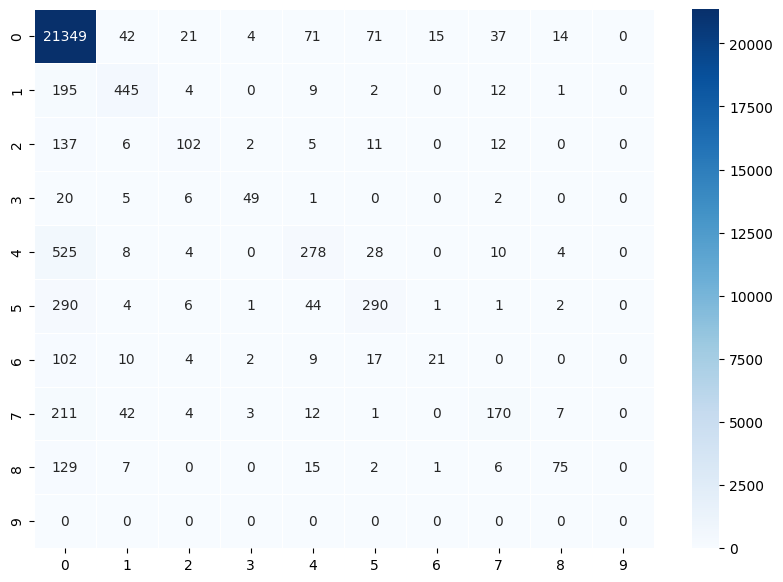

In [42]:
#9119 test on the last model
trainer.test(model,testloader,ckpt_path='best')

In [43]:
epoch_timer_callback = list(filter(lambda callback: callback.__class__ == EpochTimerCallback , trainer.callbacks))[0]

In [44]:
epoch_timer_callback.average_epochs_time

4.903769347978675

# Dotless Text

## prepare the dataset

In [45]:
train_dataset['dotless_tokens'] = list(train_dataset['tokens'].progress_apply(lambda tokens: list(map(undot,tokens))))
train_dataset

  0%|          | 0/3574 [00:00<?, ?it/s]

,tokens,tags,tags_labels,dotless_tokens
0,"[واعاد, راوول, الفارق, الى, سابق, عهده, عندما,...","[O, B-PERS, O, O, O, O, O, O, O, O, O, O, O, B...","[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[واعاد, راوول, الڡارٯ, الى, ساٮٯ, عهده, عٮدما,..."
1,"[وبحسب, الصحيفة, فإن, شركة, طيران, ريان, إير, ...","[O, O, O, O, O, B-ORG, I-ORG, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 7, 2, 0, 0, 0, 0, 0, 0]","[وٮحسٮ, الصحٮڡه, ڡاں, سركه, طٮراں, رٮاں, اٮر, ..."
2,"[4, ليتر, يولدان, قوة, 110أحصنة, و148حصاناً, ع...","[O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, لٮٮر, ٮولداں, ڡوه, 110احصٮه, و148حصاٮاً, ع..."
3,"[وفقدت, البرازيل, لقبها, بطلة, للعالم, بخسارته...","[O, B-LOC, O, O, O, O, O, B-LOC, O, O, O, O, O...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[وڡڡدٮ, الٮرارٮل, لڡٮها, ٮطله, للعالم, ٮحسارٮه..."
4,"[واعتبر, ان, "", سسياستنا, الدبلوماسية, تهدف, ب...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[واعٮٮر, اں, "", سسٮاسٮٮا, الدٮلوماسٮه, ٮهدڡ, ٮ..."
...,...,...,...,...
3569,"[وكانت, هذه, هي, اخر, مباراة, في, جولة, النادي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-O...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, ...","[وكاٮٮ, هده, هى, احر, مٮاراه, ڡى, حوله, الٮادى..."
3570,"[ولقد, ظلت, ثورة, الملك, والشعب, النبراس, الذي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ولڡد, طلٮ, ٮوره, الملك, والسعٮ, الٮٮراس, الدى..."
3571,"[لأنهم, بدلاء, للسلطة, «, .]","[O, O, O, O, O]","[0, 0, 0, 0, 0]","[لاٮهم, ٮدلاء, للسلطه, «, .]"
3572,"[فقال, :, -, نجيب, محفوظ, ترك, أثره, على, الجم...","[O, O, O, B-PERS, I-PERS, O, O, O, O, O, O, O,...","[0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ڡڡال, :, -, ٮحٮٮ, محڡوط, ٮرك, اٮره, على, الحم..."


In [46]:
train_dataset['dotless_tokens'][0],train_dataset['tokens'][0]

(['واعاد',
  'راوول',
  'الڡارٯ',
  'الى',
  'ساٮٯ',
  'عهده',
  'عٮدما',
  'سحل',
  'الهدڡ',
  'الراٮع',
  'ٮٮلڡٮه',
  'كره',
  'مں',
  'ٮٮكهام',
  'ڡاٮڡرد',
  'ٮالحارس',
  'الاوكراٮى',
  'وراوعه',
  'ڡٮل',
  'اں',
  'ٮودعها',
  'ٮٮمٮاه',
  'ٮسهوله',
  'داحل',
  'المرمى',
  '(',
  '61',
  ')',
  '.'],
 array(['واعاد', 'راوول', 'الفارق', 'الى', 'سابق', 'عهده', 'عندما', 'سجل',
        'الهدف', 'الرابع', 'بتلقيه', 'كرة', 'من', 'بيكهام', 'فانفرد',
        'بالحارس', 'الاوكراني', 'وراوغه', 'قبل', 'ان', 'يودعها', 'بيمناه',
        'بسهولة', 'داخل', 'المرمى', '(', '61', ')', '.'], dtype=object))

In [47]:
validation_dataset['dotless_tokens'] = validation_dataset['tokens'].progress_apply(lambda tokens: list(map(undot,tokens)))
validation_dataset

  0%|          | 0/398 [00:00<?, ?it/s]

,tokens,tags,tags_labels,dotless_tokens
0,"[بعد, هزيمته, في, الدورة, الأولى, في, ديربي, ع...","[O, O, O, O, O, O, B-MISC, B-LOC, B-LOC, O, B-...","[0, 0, 0, 0, 0, 0, 8, 1, 1, 0, 7, 2, 0, 0, 7, ...","[ٮعد, هرٮمٮه, ڡى, الدوره, الاولى, ڡى, دٮرٮى, ع..."
1,"[وكان, جلالة, الملك, محمد, السادس, وصاحب, السم...","[O, O, O, B-PERS, I-PERS, O, O, O, O, O, B-PER...","[0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, ...","[وكاں, حلاله, الملك, محمد, السادس, وصاحٮ, السم..."
2,"[وكانت, اعمدة, الدخان, تتصاعد, من, موقعين, في,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[وكاٮٮ, اعمده, الدحاں, ٮٮصاعد, مں, موڡعٮں, ڡى,..."
3,"[6%, خلال, النصف, الأول, من, العام, 2006, مقار...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6%, حلال, الٮصڡ, الاول, مں, العام, 2006, مڡار..."
4,"[الحقيقة, ندركها, حين, نجرب, الدخول, إلى, أحد,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-O...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, ...","[الحڡٮڡه, ٮدركها, حٮں, ٮحرٮ, الدحول, الى, احد,..."
...,...,...,...,...
393,"[يقول, :, », إنه, يقع, في, أقصى, لعبة, الشطرنج...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ٮڡول, :, », اٮه, ٮڡع, ڡى, اڡصى, لعٮه, السطرٮح..."
394,"[والذي, لا, يعرفه, عدد, كبير, من, الناس, ,, أن...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[والدى, لا, ٮعرڡه, عدد, كٮٮر, مں, الٮاس, ,, اں..."
395,"[تم, استعمال, الأسلحة, الكيميائية, في, تلك, ال...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ٮم, اسٮعمال, الاسلحه, الكٮمٮاىٮه, ڡى, ٮلك, ال..."
396,"[واضاف, ان, التقرير, الطبي, أكد, حاجة, صدام, إ...","[O, O, O, O, O, O, B-PERS, O, O, O, O]","[0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0]","[واصاڡ, اں, الٮڡرٮر, الطٮى, اكد, حاحه, صدام, ا..."


In [48]:
test_dataset['dotless_tokens'] = test_dataset['tokens'].progress_apply(lambda tokens: list(map(undot,tokens)))
test_dataset

  0%|          | 0/924 [00:00<?, ?it/s]

,tokens,tags,tags_labels,dotless_tokens
0,"[الصالحية, المفرق, -, غيث, الطراونة, -, أمر, ج...","[B-LOC, B-LOC, O, B-PERS, I-PERS, O, O, O, O, ...","[1, 1, 0, 4, 5, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, ...","[الصالحٮه, المڡرٯ, -, عٮٮ, الطراوٮه, -, امر, ح..."
1,"[برند, جلالته, خلال, اللقاء, الذي, جمعه, وأعضا...","[B-PERS, O, O, O, O, O, O, O, O, O, O, O, O, O...","[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ٮرٮد, حلالٮه, حلال, اللڡاء, الدى, حمعه, واعصا..."
2,"[مرتفع, جلالته, أريد, ان, استمع, منكم, عن, الم...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[مرٮڡع, حلالٮه, ارٮد, اں, اسٮمع, مٮكم, عں, الم..."
3,"[زادت, جلالته, على, انه, سوف, يعود, الى, الباد...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[رادٮ, حلالٮه, على, اٮه, سوڡ, ٮعود, الى, الٮاد..."
4,"[لصادرات, جلالة, الملك, اطلق, في, ايار, الماضي...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[لصادراٮ, حلاله, الملك, اطلٯ, ڡى, اٮار, الماصى..."
...,...,...,...,...
919,"[الإلكترون, الرغم, من, تصريحه, أكثر, من, مرة, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[الالكٮروں, الرعم, مں, ٮصرٮحه, اكٮر, مں, مره, ..."
920,"["", الأمير, السعودي, في, قطاعات, استثمارية, مت...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ORG,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 2, ...","["", الامٮر, السعودى, ڡى, ڡطاعاٮ, اسٮٮمارٮه, مٮ..."
921,"[وتتهم, بن, طلال, شهادة, البكالوريوس, في, إدار...","[O, I-PERS, I-PERS, O, O, O, O, O, O, O, O, O,...","[0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[وٮٮهم, ٮں, طلال, سهاده, الٮكالورٮوس, ڡى, ادار..."
922,"[ذلك, ،, يتابع, الوليد, بن, طلال, أعماله, التج...","[O, O, O, B-PERS, I-PERS, B-PERS, O, O, O, O, ...","[0, 0, 0, 4, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[دلك, ،, ٮٮاٮع, الولٮد, ٮں, طلال, اعماله, الٮح..."


In [49]:
test_dataset['dotless_tokens'][0],test_dataset['tokens'][0]

(['الصالحٮه',
  'المڡرٯ',
  '-',
  'عٮٮ',
  'الطراوٮه',
  '-',
  'امر',
  'حلاله',
  'الملك',
  'عٮدالله',
  'الٮاٮى',
  'امس',
  'ٮٮٮڡٮد',
  'حرمه',
  'مں',
  'المسارٮع',
  'الٮعلٮمٮه',
  'والصحٮه',
  'والٮٮموٮه',
  'واحرى',
  'مرٮٮطه',
  'ٮالاٮدٮه',
  'السٮاٮٮه',
  'و',
  '27',
  'وحده',
  'سكٮٮه',
  'ڡى',
  'ڡصاء',
  'الصالحٮه',
  'وٮاٮڡه',
  'ڡى',
  'الٮادٮه',
  'السرڡٮه',
  'حلال',
  'سٮه',
  'اسهر',
  'ٮٮموٮل',
  'مں',
  'الدٮواں',
  'الملكى',
  'الهاسمى',
  '.'],
 array(['الصالحية', 'المفرق', '-', 'غيث', 'الطراونة', '-', 'أمر', 'جلالة',
        'الملك', 'عبدالله', 'الثاني', 'أمس', 'بتنفيذ', 'حزمة', 'من',
        'المشاريع', 'التعليمية', 'والصحية', 'والتنموية', 'وأخرى', 'مرتبطة',
        'بالأندية', 'الشبابية', 'و', '27', 'وحدة', 'سكنية', 'في', 'قضاء',
        'الصالحية', 'ونايفة', 'في', 'البادية', 'الشرقية', 'خلال', 'ستة',
        'اشهر', 'بتمويل', 'من', 'الديوان', 'الملكي', 'الهاشمي', '.'],
       dtype=object))

## create the tokenizer

In [50]:
dotless_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [51]:
dotless_tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['dotless_tokens']))

Training WordTokenizer ...


In [52]:
dotless_tokenizer.vocab_size

24334

In [53]:
# test the tokenizer
dotless_tokenizer.tokenize('على في , hello')

['على', '<UNK>', ',', '<UNK>']

## tokenize and split

In [54]:
dotless_encoded_trainset,dotless_trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['dotless_tokens'],
    tags_list=train_dataset['tags_labels'],
    tokenizer=dotless_tokenizer,
  )
dotless_encoded_valset,dotless_valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['dotless_tokens'],
    tags_list=validation_dataset['tags_labels'],
    tokenizer=dotless_tokenizer,
  )
dotless_encoded_testset,dotless_testy = create_features_from_tokens_list(
    tokens_list=test_dataset['dotless_tokens'],
    tags_list=test_dataset['tags_labels'],
    tokenizer=dotless_tokenizer,
  )
dotless_encoded_trainset.shape,dotless_trainy.shape,dotless_encoded_valset.shape,dotless_valy.shape,dotless_encoded_testset.shape,dotless_testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((3574, 220), (3574, 220), (398, 220), (398, 220), (924, 220), (924, 220))

In [55]:
# create tensor datasets
dotless_trainset = TensorDataset(torch.from_numpy(dotless_encoded_trainset), torch.from_numpy(dotless_trainy))
dotless_validset = TensorDataset(torch.from_numpy(dotless_encoded_valset), torch.from_numpy(dotless_valy))
dotless_testset = TensorDataset(torch.from_numpy(dotless_encoded_testset), torch.from_numpy(dotless_testy))

In [56]:
# create dataloaders
dotless_trainloader = DataLoader(dotless_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
dotless_valloader = DataLoader(dotless_validset, shuffle=False, batch_size=batch_size,num_workers=4)
dotless_testloader = DataLoader(dotless_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [57]:
model = LitBiLSTMModel(vocab_size=dotless_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (test_recall): MulticlassRecall()
  (test_precision): MulticlassPrecision()
  (test_f1_score): MulticlassF1Score()
  (embedding): Embedding(24334, 256)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [58]:
trainer = train_model(
    model,
    train_dataloader=dotless_trainloader,
    val_dataloader=dotless_valloader,
    text_type='dotless-text',
  )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.2756261825561523     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name              ┃ Type                ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ train_accuracy    │ MulticlassAccuracy  │      0 │
│ 1  │ val_accuracy      │ MulticlassAccuracy  │      0 │
│ 2  │ test_accuracy     │ MulticlassAccuracy  │      0 │
│ 3  │ test_recall       │ MulticlassRecall    │      0 │
│ 4  │ test_precision    │ MulticlassPrecision │      0 │
│ 5  │ test_f1_score     │ MulticlassF1Score   │      0 │
│ 6  │ embedding         │ Embedding           │  6.2 M │
│ 7  │ lstm              │ LSTM                │ 15.8 M │
│ 8  │ dropout           │ Dropout             │      0 │
│ 9  │ embedding_dropout │ Dropout             │      0 │
│ 10 │ fc                │ Linear              │  5.1 K │
└────┴───────────────────┴─────────────────────┴────────┘

Trainable params: 22.0 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 22.0 M                                                                                               
Total estimated model params size (MB): 87

Output()

Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.

Epoch 00020: reducing learning rate of group 0 to 2.5000e-04.

Restoring states from the checkpoint path at /home/majed_alshaibani/Experiments/DotlessArabic/NER/dotless-text/checkpoints/epoch=15-val_loss=0.203-step=224.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/majed_alshaibani/Experiments/DotlessArabic/NER/dotless-text/checkpoints/epoch=15-val_loss=0.203-step=224.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9130377173423767     │
│       test_f1_score       │    0.5534211993217468     │
│         test_loss         │    0.4390001595020294     │
│      test_precision       │    0.7081059813499451     │
│        test_recall        │    0.4811074137687683     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9130377173423767,
  'test_precision': 0.7081059813499451,
  'test_recall': 0.4811074137687683,
  'test_f1_score': 0.5534211993217468,
  'test_loss': 0.4390001595020294}]

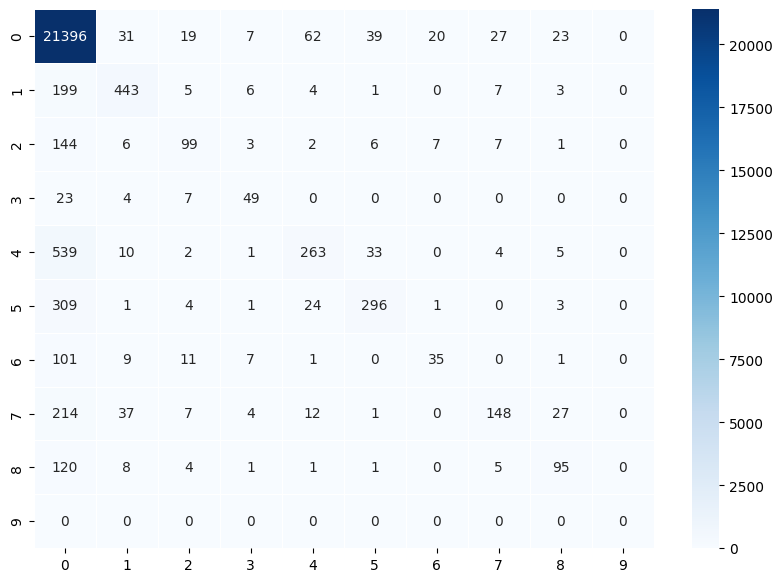

In [59]:
# test on the last model
trainer.test(model,dotless_testloader,ckpt_path='best')

In [60]:
epoch_timer_callback = list(filter(lambda callback: callback.__class__ == EpochTimerCallback , trainer.callbacks))[0]

In [61]:
epoch_timer_callback.average_epochs_time

5.279452630451748